# 1 Loading Data

In [3]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import mlflow
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import hvplot.pandas
import pickle
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

import hvplot.pandas



ModuleNotFoundError: No module named 'pandas'

In [3]:
# data = pd.read_csv(r'D:\ML Prep\Projects\Loan_Defaults_Prediction\data\accepted_2007_to_2018q4.csv\accepted_2007_to_2018Q4.csv')

# data = data[['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length','home_ownership','annual_inc','verification_status','issue_d','loan_status','purpose','title','zip_code','addr_state','dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util','total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies']]


# data.to_csv(r'D:\ML Prep\Projects\Loan_Defaults_Prediction\data\accepeted_custom.csv', index = False)

In [4]:
data = pd.read_csv(r'D:\ML Prep\Projects\Loan_Defaults_Prediction\data\accepeted_custom.csv')

# 2 Data Definition

| LoanStatNew           | Description                                                                                                                |
|-----------------------|----------------------------------------------------------------------------------------------------------------------------|
| loan_amnt             | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
| term                  | The number of payments on the loan. Values are in months and can be either 36 or 60.                                        |
| int_rate              | Interest Rate on the loan                                                                                                   |
| installment           | The monthly payment owed by the borrower if the loan originates.                                                           |
| grade                 | LC assigned loan grade                                                                                                      |
| sub_grade             | LC assigned loan subgrade                                                                                                   |
| emp_title             | The job title supplied by the Borrower when applying for the loan.                                                          |
| emp_length            | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. |
| home_ownership        | The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER |
| annual_inc            | The self-reported annual income provided by the borrower during registration.                                               |
| verification_status   | Indicates if income was verified by LC, not verified, or if the income source was verified                                  |
| issue_d               | The month which the loan was funded                                                                                         |
| loan_status           | Current status of the loan                                                                                                  |
| purpose               | A category provided by the borrower for the loan request.                                                                   |
| title                 | The loan title provided by the borrower                                                                                     |
| zip_code              | The first 3 numbers of the zip code provided by the borrower in the loan application.                                       |
| addr_state            | The state provided by the borrower in the loan application                                                                  |
| dti                   | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. |
| earliest_cr_line      | The month the borrower's earliest reported credit line was opened                                                           |
| open_acc              | The number of open credit lines in the borrower's credit file.                                                              |
| pub_rec               | Number of derogatory public records                                                                                         |
| revol_bal             | Total credit revolving balance                                                                                              |
| revol_util            | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.  |
| total_acc             | The total number of credit lines currently in the borrower's credit file                                                    |
| initial_list_status   | The initial listing status of the loan. Possible values are – W, F                                                          |
| application_type      | Indicates whether the loan is an individual application or a joint application with two co-borrowers                        |
| mort_acc              | Number of mortgage accounts.                                                                                                |
| pub_rec_bankruptcies  | Number of public record bankruptcies                                                                                        |


In [5]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,190xx,PA,5.91,Aug-2003,7.00,0.00,2765.00,29.70,13.00,w,Individual,1.00,0.00
1,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,small_business,Business,577xx,SD,16.06,Dec-1999,22.00,0.00,21470.00,19.20,38.00,w,Individual,4.00,0.00
2,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,Dec-2015,Fully Paid,home_improvement,NaN,605xx,IL,10.78,Aug-2000,6.00,0.00,7869.00,56.20,18.00,w,Joint App,5.00,0.00
3,35000.00,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.00,Source Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,076xx,NJ,17.06,Sep-2008,13.00,0.00,7802.00,11.60,17.00,w,Individual,1.00,0.00
4,10400.00,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.00,Source Verified,Dec-2015,Fully Paid,major_purchase,Major purchase,174xx,PA,25.37,Jun-1998,12.00,0.00,21929.00,64.50,35.00,w,Individual,6.00,0.00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 28 columns):
 #   Column                Dtype  
---  ------                -----  
 0   loan_amnt             float64
 1   term                  object 
 2   int_rate              float64
 3   installment           float64
 4   grade                 object 
 5   sub_grade             object 
 6   emp_title             object 
 7   emp_length            object 
 8   home_ownership        object 
 9   annual_inc            float64
 10  verification_status   object 
 11  issue_d               object 
 12  loan_status           object 
 13  purpose               object 
 14  title                 object 
 15  zip_code              object 
 16  addr_state            object 
 17  dti                   float64
 18  earliest_cr_line      object 
 19  open_acc              float64
 20  pub_rec               float64
 21  revol_bal             float64
 22  revol_util            float64
 23  total_a

In [7]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,2260668.00,2260668.00,2260668.00,2260664.00,2258957.00,2260639.00,2260639.00,2260668.00,2258866.00,2260639.00,2210638.00,2259303.00
mean,15046.93,13.09,445.81,77992.43,18.82,11.61,0.20,16658.46,50.34,24.16,1.56,0.13
std,9190.25,4.83,267.17,112696.20,14.18,5.64,0.57,22948.31,24.71,11.99,1.90,0.36
min,500.00,5.31,4.93,0.00,-1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
25%,8000.00,9.49,251.65,46000.00,11.89,8.00,0.00,5950.00,31.50,15.00,0.00,0.00
50%,12900.00,12.62,377.99,65000.00,17.84,11.00,0.00,11324.00,50.30,22.00,1.00,0.00
75%,20000.00,15.99,593.32,93000.00,24.49,14.00,0.00,20246.00,69.40,31.00,3.00,0.00
max,40000.00,30.99,1719.83,110000000.00,999.00,101.00,86.00,2904836.00,892.30,176.00,94.00,12.00


In [8]:
data.select_dtypes(include=['int','float'])

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,3600.00,13.99,123.03,55000.00,5.91,7.00,0.00,2765.00,29.70,13.00,1.00,0.00
1,24700.00,11.99,820.28,65000.00,16.06,22.00,0.00,21470.00,19.20,38.00,4.00,0.00
2,20000.00,10.78,432.66,63000.00,10.78,6.00,0.00,7869.00,56.20,18.00,5.00,0.00
3,35000.00,14.85,829.90,110000.00,17.06,13.00,0.00,7802.00,11.60,17.00,1.00,0.00
4,10400.00,22.45,289.91,104433.00,25.37,12.00,0.00,21929.00,64.50,35.00,6.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,40000.00,10.49,859.56,227000.00,12.75,5.00,0.00,8633.00,64.90,37.00,3.00,0.00
2260697,24000.00,14.49,564.56,110000.00,18.30,10.00,1.00,17641.00,68.10,31.00,2.00,1.00
2260698,14000.00,14.49,329.33,95000.00,23.36,8.00,0.00,7662.00,54.00,22.00,1.00,0.00
2260699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3 EDA

In [9]:
numerical_cols = data.select_dtypes(include=['int','float']).columns
cat_cols = data.select_dtypes(include=['object']).columns

## Dependent Variable

In [10]:
data['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', 
    width=500, height=350
)


:Bars   [loan_status]   (count)

For our business case we can consider only the Fully Paid and Charge off records, as we rae trying to predict who will possibly default.

In [11]:
data = data[data['loan_status'].isin(['Fully Paid','Charged Off'])]

data['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', 
    width=500, height=350
)


:Bars   [loan_status]   (count)

## Heatmap

<Axes: >

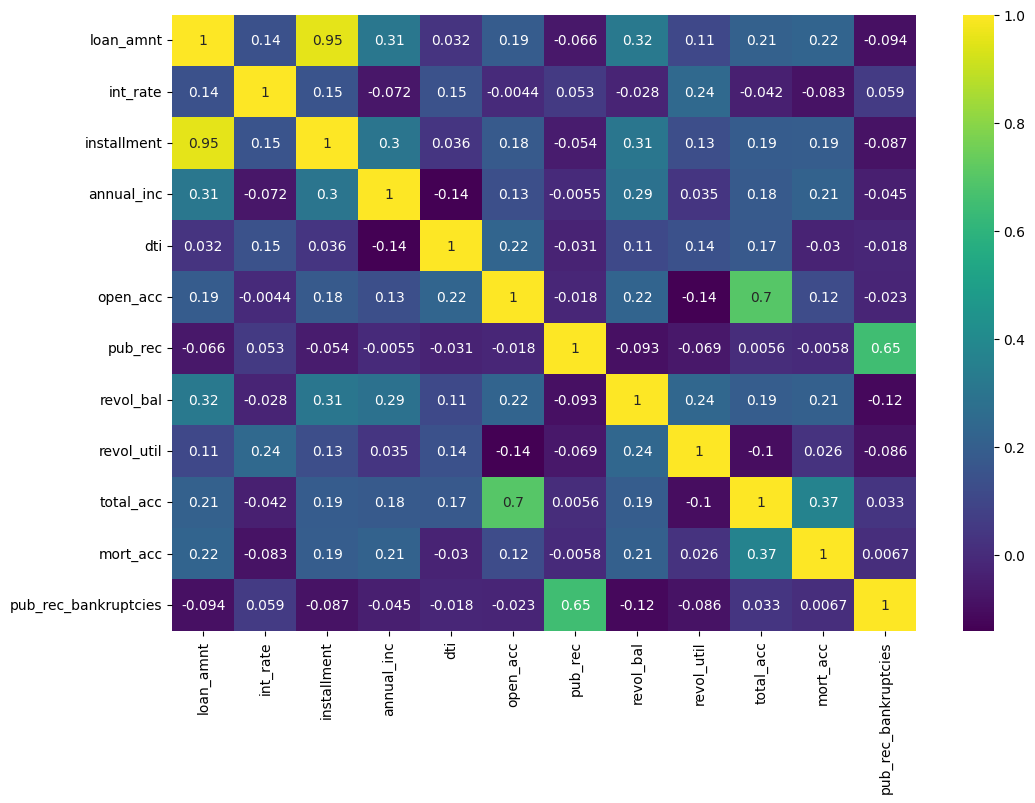

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='viridis')

We noticed almost perfect correlation between "loan_amnt" the "installment" feature. We'll explore this features further. Print out their descriptions and perform a scatterplot between them.

Does this relationship make sense to you?
Do we think there is duplicate information here?

In [13]:
installment = data.hvplot.hist(
    y='installment', by='loan_status', subplots=False, 
    width=350, height=400, bins=50, alpha=0.4, 
    title="Installment by Loan Status", 
    xlabel='Installment', ylabel='Counts', legend='top'
)

loan_amnt = data.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False, 
    width=350, height=400, bins=30, alpha=0.4, 
    title="Loan Amount by Loan Status", 
    xlabel='Loan Amount', ylabel='Counts', legend='top'
)

installment + loan_amnt

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (Count)

In [14]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00,15565.06,8814.56,900.00,9000.00,14350.00,20400.00,40000.00
Fully Paid,1076751.00,14134.37,8669.03,500.00,7500.00,12000.00,20000.00,40000.00


## grade & sub_grade


In [15]:

print(f"GRADE unique: {data.grade.unique()}")
print(f"SUB_GRADE unique: {data.sub_grade.unique()}")


GRADE unique: ['C' 'B' 'F' 'A' 'E' 'D' 'G']
SUB_GRADE unique: ['C4' 'C1' 'B4' 'F1' 'C3' 'B2' 'B1' 'A2' 'B5' 'C2' 'E2' 'A4' 'E3' 'C5'
 'A1' 'D4' 'F3' 'D1' 'B3' 'D3' 'D5' 'A5' 'F2' 'E4' 'D2' 'E1' 'F5' 'E5'
 'A3' 'G2' 'G1' 'G3' 'G4' 'F4' 'G5']


In [16]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'sub_grade'].value_counts().hvplot.bar(title = 'Fully Paid') 
charged_off = data.loc[data['loan_status']=='Charged Off', 'sub_grade'].value_counts().hvplot.bar(title = 'Charged off') 
fully_paid + charged_off

:Layout
   .Bars.Count.I  :Bars   [sub_grade]   (count)
   .Bars.Count.II :Bars   [sub_grade]   (count)

In [17]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'grade'].value_counts().hvplot.bar(label =  'Fully Paid') 
charged_off = data.loc[data['loan_status']=='Charged Off', 'grade'].value_counts().hvplot.bar(label='Charge off') 

fully_paid * charged_off

:Overlay
   .Bars.Fully_Paid :Bars   [grade]   (count)
   .Bars.Charge_off :Bars   [grade]   (count)

It looks like F and G subgrades don't get paid back that often. Isloate those and recreate the countplot just for those subgrades.



## term

In [18]:
data.home_ownership.value_counts().hvplot.bar()

:Bars   [home_ownership]   (count)

In [19]:
data.term.value_counts()

term
36 months    1020743
60 months     324567
Name: count, dtype: int64

In [20]:
grouped_data = data.groupby(['home_ownership', 'loan_status']).size().unstack().fillna(0)

In [21]:
data.groupby(['home_ownership', 'loan_status']).size().unstack()

loan_status,Charged Off,Fully Paid
home_ownership,,
ANY,56,230
MORTGAGE,114531,551048
NONE,7,41
OTHER,27,117
OWN,29864,114968
RENT,124074,410347


In [22]:
grouped_data = data.groupby(['home_ownership', 'loan_status']).size().unstack().fillna(0)

# Plot the bar chart with different colors for loan_Status categories
plot = grouped_data.hvplot.bar(stacked=False, rot=45, title='Home Ownership by Loan Status')
plot

:Bars   [home_ownership,loan_status]   (value)

In [23]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

home_ownership
MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: count, dtype: int64

## home_ownership, verification_status & purpose


c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\se

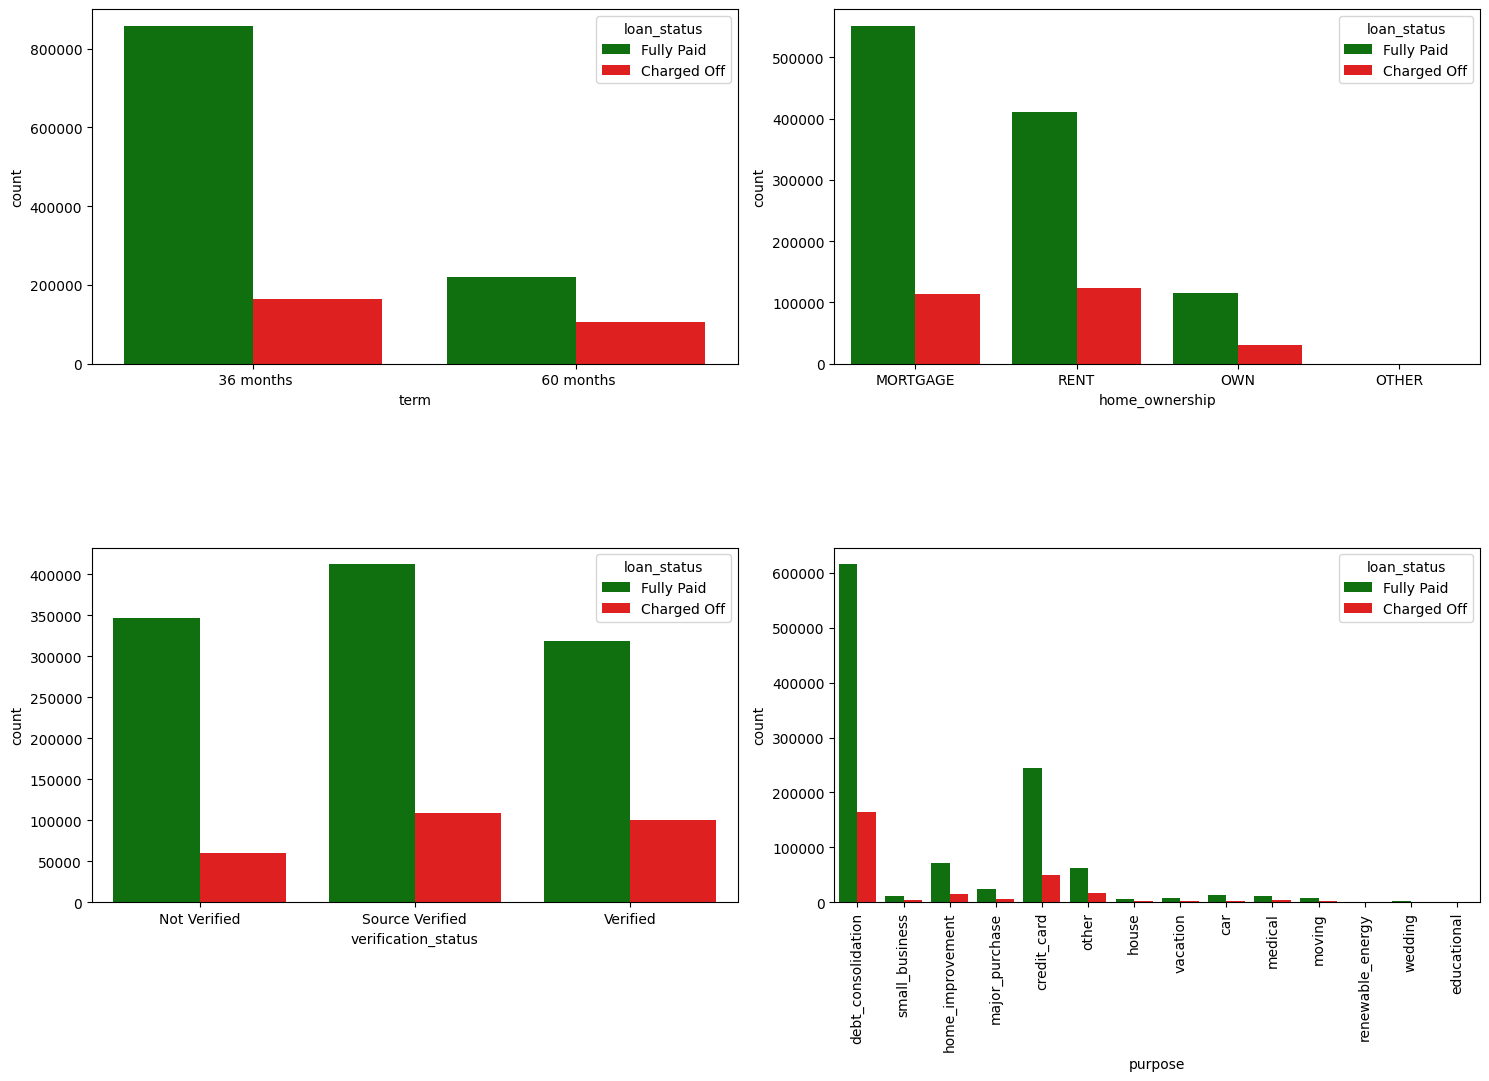

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(15, 20))

# Define the color palette
palette = {'Fully Paid': 'green', 'Charged Off': 'red'}

# Plot 1
plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status', palette=palette)

# Plot 2
plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status', palette=palette)

# Plot 3
plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status', palette=palette)

# Plot 4
plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status', palette=palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Display the plots
plt.tight_layout()
plt.show()


## int_rate & annual_inc

- int_rate: Interest Rate on the loan
- annual_inc: The self-reported annual income provided by the borrower during registration

c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


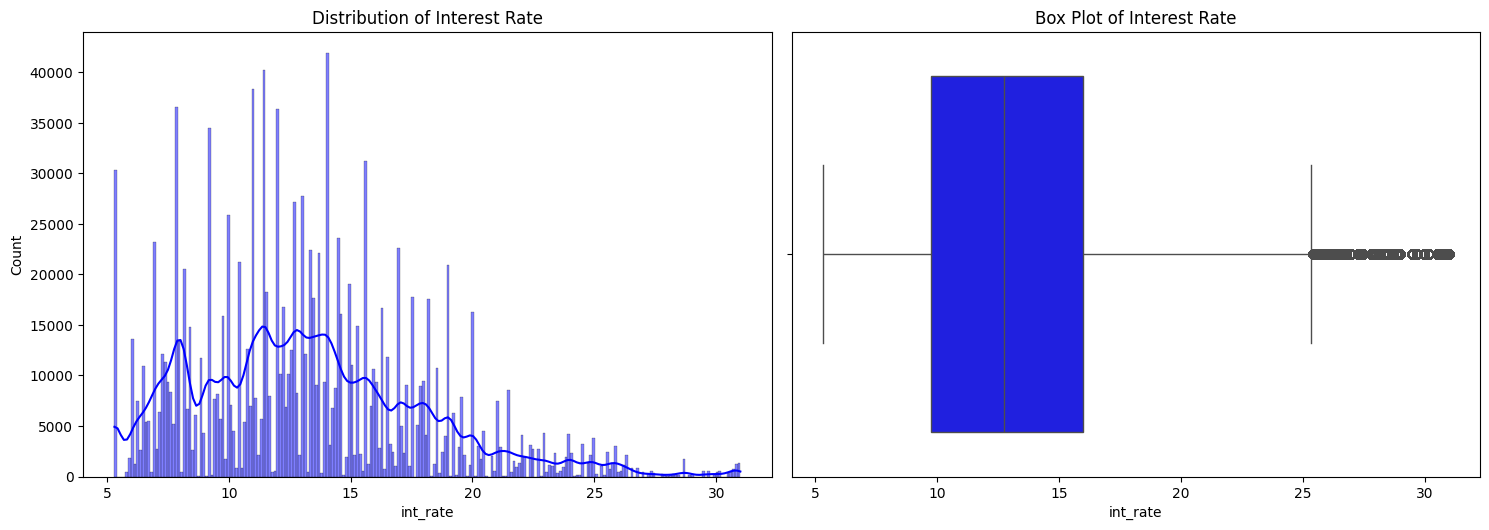

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(15, 10))

# Histogram for int_rate
plt.subplot(2, 2, 1)
sns.histplot(data['int_rate'], kde=True, color='blue')
plt.title('Distribution of Interest Rate')

# Box Plot for int_rate
plt.subplot(2, 2, 2)
sns.boxplot(x=data['int_rate'], color='blue')
plt.title('Box Plot of Interest Rate')

# Display the plots
plt.tight_layout()
plt.show()


c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


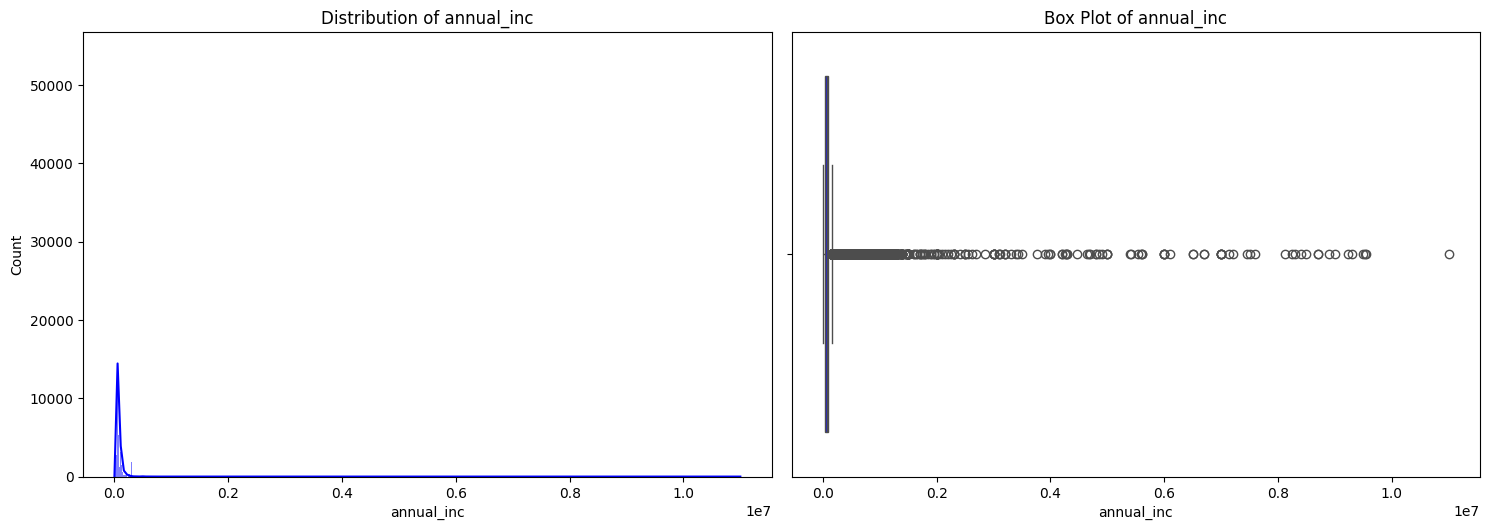

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(15, 10))

# Histogram for int_rate
plt.subplot(2, 2, 1)
sns.histplot(data['annual_inc'], kde=True, color='blue')
plt.title('Distribution of annual_inc')

# Box Plot for int_rate
plt.subplot(2, 2, 2)
sns.boxplot(x=data['annual_inc'], color='blue')
plt.title('Box Plot of annual_inc')

# Display the plots
plt.tight_layout()
plt.show()


In [27]:
int_rate = data.hvplot.hist(
    y='int_rate', by='loan_status', alpha=0.3, width=350, height=400,
    title="Loan Status by Interest Rate", xlabel='Interest Rate', ylabel='Loans Counts', 
    legend='top'
)

annual_inc = data.hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Annual Income", xlabel='Annual Income', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

int_rate + annual_inc


:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [int_rate]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [annual_inc]   (Count)

In [28]:
annual_inc = data[data.annual_inc <= 250000 ].hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Annual Income less than 250k", xlabel='Annual Income', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

annual_inc

:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (Count)

In [29]:
print(f' Percentage of records with annual inc greater than 250 k : {(data[data.annual_inc > 250000].shape[0]/data.shape[0])* 100}')
print(f' Percentage of records with annual inc greater than 1M : {(data[data.annual_inc > 1000000].shape[0]/data.shape[0])* 100}')
print(f' Percentage of records with annual inc greater than 100 k : {(data[data.annual_inc > 100000].shape[0]/data.shape[0])* 100}')


 Percentage of records with annual inc greater than 250 k : 0.9995465729088463
 Percentage of records with annual inc greater than 1M : 0.02155636990730761
 Percentage of records with annual inc greater than 100 k : 18.586125131010697


In [30]:
data.loc[data.annual_inc > 250000,'loan_status'].value_counts()

loan_status
Fully Paid     11699
Charged Off     1748
Name: count, dtype: int64

## issue_d, earliest_cr_line

- issue_d: The month which the loan was funded
- earliest_cr_line: The month the borrower's earliest reported credit line was opened


In [31]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

In [32]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'issue_d'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'issue_d'].hvplot.hist(bins=35)
(fully_paid*charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

:Overlay
   .Histogram.I  :Histogram   [issue_d]   (Count)
   .Histogram.II :Histogram   [issue_d]   (Count)

## dti, open_acc, revol_bal, revol_util, & total_acc
- dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, - excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- open_acc: The number of open credit lines in the borrower's credit file.
- revol_bal: Total credit revolving balance
- revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all - available revolving credit.
- total_acc: The total number of credit lines currently in the borrower's credit file

In [33]:
dti = data.hvplot.hist(
    y='dti', bins=50, width=350, height=350, 
    title="dti Distribution", xlabel='dti', ylabel='Count'
)
dti

:Histogram   [dti]   (Count)

In [34]:
open_acc = data.hvplot.hist(
    y='open_acc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Open Acc", xlabel='# open_acc', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

total_acc = data.hvplot.hist(
    y='total_acc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Total Acc", xlabel='# total_acc', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

open_acc + total_acc 

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [open_acc]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [total_acc]   (Count)

In [35]:
revol_bal = data.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Revolving Bal", xlabel='revol_bal', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

revol_util = data.hvplot.hist(
    y='revol_util', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Revolving Util", xlabel='revol_util', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

revol_bal + revol_util 

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (Count)

## pub_rec, initial_list_status, application_type, mort_acc, & pub_rec_bankruptcies¶
- pub_rec: Number of derogatory public records
- initial_list_status: The initial listing status of the loan. Possible values are – W, F
- application_type: Indicates whether the loan is an individual application or a joint application with two - co-borrowers
- mort_acc: Number of mortgage accounts
- pub_rec_bankruptcies: Number of public record bankruptcies

In [36]:
mort_acc = data.hvplot.hist(
    y='mort_acc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by mort_acc", xlabel='mort_acc', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

pub_rec_bankruptcies = data.hvplot.hist(
    y='pub_rec_bankruptcies', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by pub_rec_bankruptcies", xlabel='pub_rec_bankruptcies', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

pub_rec = data.hvplot.hist(
    y='pub_rec', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by pub_rec", xlabel='pub_rec', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

mort_acc + pub_rec_bankruptcies + pub_rec
 

:Layout
   .NdOverlay.I   :NdOverlay   [loan_status]
      :Histogram   [mort_acc]   (Count)
   .NdOverlay.II  :NdOverlay   [loan_status]
      :Histogram   [pub_rec_bankruptcies]   (Count)
   .NdOverlay.III :NdOverlay   [loan_status]
      :Histogram   [pub_rec]   (Count)

In [37]:
data.initial_list_status

0          w
1          w
2          w
4          w
5          w
          ..
2260688    f
2260690    f
2260691    f
2260692    f
2260697    f
Name: initial_list_status, Length: 1345310, dtype: object

In [38]:
xlabel = "Laon status by application_type"
title = "Loan Status by application_type"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'application_type'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'application_type'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [application_type]   (count)
   .Bars.Count.II :Bars   [application_type]   (count)

In [39]:
xlabel = "The initial listing status of the loan"
title = "Loan Status by The initial listing status of the loan"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'initial_list_status'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'initial_list_status'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [initial_list_status]   (count)
   .Bars.Count.II :Bars   [initial_list_status]   (count)

## Correlation - Numberic Features vs Target Variable


In [40]:
data['loan_status'] = data.loan_status.map({'Fully Paid':0, 'Charged Off':1})


In [41]:
data[[*numerical_cols,'loan_status']].corr()['loan_status'].drop('loan_status').sort_values().hvplot.barh(
    width=600, height=400, 
    title="Correlation between Loan status and Numeric Features", 
    ylabel='Correlation', xlabel='Numerical Features', 
)

:Bars   [index]   (loan_status)

# 4 Data Cleaning

## Missing Values

In [42]:
print('Total Rows : ', data.shape[0])
data.isnull().sum()[data.isnull().sum() > 100]

Total Rows :  1345310


emp_title               85785
emp_length              78511
title                   16660
dti                       374
revol_util                857
mort_acc                47281
pub_rec_bankruptcies      697
dtype: int64

We can drop the emp_title,emp_length,title,mort_acc columns as they have so many null values

In [43]:
data.drop(columns = ['emp_title','emp_length','title'], inplace=True)

We can drop the rows with null values for dti,revol_util,mort_acc,pub_rec_bankruptcies considering the total number of rows

In [44]:
data.dropna(inplace=True)

In [45]:
print('Total Rows : ', data.shape[0])
data.isnull().sum()

Total Rows :  1296860


loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
zip_code                0
addr_state              0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
dtype: int64

In [46]:
data.drop(columns = ['sub_grade'], inplace = True)

Grade has child column sub-grade, so we can drop the grade column. But there are many sub grades and beacuse of the compute limit, I'm dropping subgarde instead of grade.

In [47]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [48]:
numerical_cols = data.select_dtypes(include=['int','float']).columns
cat_cols = data.select_dtypes(include=['object']).columns

In [49]:
cat_cols

Index(['term', 'grade', 'home_ownership', 'verification_status', 'purpose',
       'zip_code', 'addr_state', 'initial_list_status', 'application_type'],
      dtype='object')

In [50]:
for i in cat_cols:
    print(f'# Unique Values in {i}: {data[i].nunique()}')

# Unique Values in term: 2
# Unique Values in grade: 7
# Unique Values in home_ownership: 4
# Unique Values in verification_status: 3
# Unique Values in purpose: 14
# Unique Values in zip_code: 942
# Unique Values in addr_state: 51
# Unique Values in initial_list_status: 2
# Unique Values in application_type: 2


We can drop the zip code,province as it has too many uique values

In [51]:
data.drop(columns = ['zip_code','addr_state'], inplace = True)

In [52]:
cat_cols = data.select_dtypes(include=['object']).columns.to_list()
cat_cols

['term',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

In [53]:
for i in cat_cols:
    print(f'# Unique Values in {i}: {data[i].nunique()}')

# Unique Values in term: 2
# Unique Values in grade: 7
# Unique Values in home_ownership: 4
# Unique Values in verification_status: 3
# Unique Values in purpose: 14
# Unique Values in initial_list_status: 2
# Unique Values in application_type: 2


Let's OneHot Encode other categorical features exc

In [54]:
data.dtypes

loan_amnt                      float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                      int64
purpose                         object
dti                            float64
earliest_cr_line        datetime64[ns]
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
initial_list_status             object
application_type                object
mort_acc                       float64
pub_rec_bankruptcies           float64
dtype: object

In [55]:
# issue_d
# This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

data.drop('issue_d', axis=1, inplace=True)

In [56]:
data.earliest_cr_line.dt.year.nunique()

72

In [57]:
cat_cols = data.select_dtypes(include=['object']).columns.to_list()
cat_cols

['term',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

We can drop earliest_cr_line as it has many unique years and it will not add any value if add all the years

In [58]:
data.drop(columns = ['earliest_cr_line'], inplace = True)

# 5 Pre Processing

## Encoding

In [59]:
data['term'] = data.term.map({' 36 months': 36, ' 60 months': 60})

In [60]:
ohe = OneHotEncoder()
df1 = ohe.fit_transform(data[cat_cols])
df1 = pd.DataFrame(df1.toarray(), columns=ohe.get_feature_names_out(), dtype=int)


In [61]:
data

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,3600.00,36,13.99,123.03,C,MORTGAGE,55000.00,Not Verified,0,debt_consolidation,5.91,7.00,0.00,2765.00,29.70,13.00,w,Individual,1.00,0.00
1,24700.00,36,11.99,820.28,C,MORTGAGE,65000.00,Not Verified,0,small_business,16.06,22.00,0.00,21470.00,19.20,38.00,w,Individual,4.00,0.00
2,20000.00,60,10.78,432.66,B,MORTGAGE,63000.00,Not Verified,0,home_improvement,10.78,6.00,0.00,7869.00,56.20,18.00,w,Joint App,5.00,0.00
4,10400.00,60,22.45,289.91,F,MORTGAGE,104433.00,Source Verified,0,major_purchase,25.37,12.00,0.00,21929.00,64.50,35.00,w,Individual,6.00,0.00
5,11950.00,36,13.44,405.18,C,RENT,34000.00,Source Verified,0,debt_consolidation,10.20,5.00,0.00,8822.00,68.40,6.00,w,Individual,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.00,60,9.49,377.95,B,OWN,130000.00,Not Verified,0,home_improvement,20.59,17.00,0.00,23833.00,34.00,39.00,f,Individual,3.00,0.00
2260690,29400.00,60,13.99,683.94,C,MORTGAGE,180792.00,Not Verified,0,debt_consolidation,22.03,16.00,0.00,77480.00,85.20,32.00,f,Individual,3.00,0.00
2260691,32000.00,60,14.49,752.74,C,MORTGAGE,157000.00,Source Verified,1,home_improvement,10.34,14.00,0.00,111598.00,27.40,18.00,f,Individual,3.00,0.00
2260692,16000.00,60,12.79,362.34,C,RENT,150000.00,Not Verified,0,medical,12.25,12.00,4.00,7700.00,55.00,28.00,f,Individual,0.00,3.00


In [62]:
numerical_cols = data.select_dtypes(include=['int','float']).columns
cat_cols = data.select_dtypes(include=['object']).columns

len(data.columns) == len(numerical_cols) + len(cat_cols)

True

In [63]:
#data.drop(columns=cat_cols, inplace= True)
data_final = pd.concat([data[numerical_cols].reset_index(drop = True),df1],axis = 1) 
data_final

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_36,term_60,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,3600.00,36,13.99,123.03,55000.00,0,5.91,7.00,0.00,2765.00,29.70,13.00,1.00,0.00,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,24700.00,36,11.99,820.28,65000.00,0,16.06,22.00,0.00,21470.00,19.20,38.00,4.00,0.00,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
2,20000.00,60,10.78,432.66,63000.00,0,10.78,6.00,0.00,7869.00,56.20,18.00,5.00,0.00,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,10400.00,60,22.45,289.91,104433.00,0,25.37,12.00,0.00,21929.00,64.50,35.00,6.00,0.00,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
4,11950.00,36,13.44,405.18,34000.00,0,10.20,5.00,0.00,8822.00,68.40,6.00,0.00,0.00,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296855,18000.00,60,9.49,377.95,130000.00,0,20.59,17.00,0.00,23833.00,34.00,39.00,3.00,0.00,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1296856,29400.00,60,13.99,683.94,180792.00,0,22.03,16.00,0.00,77480.00,85.20,32.00,3.00,0.00,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1296857,32000.00,60,14.49,752.74,157000.00,1,10.34,14.00,0.00,111598.00,27.40,18.00,3.00,0.00,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1296858,16000.00,60,12.79,362.34,150000.00,0,12.25,12.00,4.00,7700.00,55.00,28.00,0.00,3.00,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


In [64]:
data_final.shape[0] == data.shape[0]

True

In [65]:
# # def map_term(data):
# #     return data.map({' 36 months': 36, ' 60 months': 60}).values.reshape(-1, 1)

# # Create the ColumnTransformer with OneHotEncoder and custom transformer
# column_transformer = ColumnTransformer(
#     transformers=[
#         ('ohe', OneHotEncoder(), cat_cols),
#         # ('term_mapper', FunctionTransformer(map_term, validate=False), 'term')
#     ],
#     remainder='passthrough'  # Keep the other columns as they are
# )

# # Apply the transformation
# data_transformed = column_transformer.fit_transform(data)

# # Convert the result back to a DataFrame
# data_transformed = pd.DataFrame(data_transformed, columns=column_transformer.get_feature_names_out())

# # Display the transformed data
# print(data_transformed)

In [66]:
data_final

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_36,term_60,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,3600.00,36,13.99,123.03,55000.00,0,5.91,7.00,0.00,2765.00,29.70,13.00,1.00,0.00,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,24700.00,36,11.99,820.28,65000.00,0,16.06,22.00,0.00,21470.00,19.20,38.00,4.00,0.00,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
2,20000.00,60,10.78,432.66,63000.00,0,10.78,6.00,0.00,7869.00,56.20,18.00,5.00,0.00,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,10400.00,60,22.45,289.91,104433.00,0,25.37,12.00,0.00,21929.00,64.50,35.00,6.00,0.00,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
4,11950.00,36,13.44,405.18,34000.00,0,10.20,5.00,0.00,8822.00,68.40,6.00,0.00,0.00,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296855,18000.00,60,9.49,377.95,130000.00,0,20.59,17.00,0.00,23833.00,34.00,39.00,3.00,0.00,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1296856,29400.00,60,13.99,683.94,180792.00,0,22.03,16.00,0.00,77480.00,85.20,32.00,3.00,0.00,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1296857,32000.00,60,14.49,752.74,157000.00,1,10.34,14.00,0.00,111598.00,27.40,18.00,3.00,0.00,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1296858,16000.00,60,12.79,362.34,150000.00,0,12.25,12.00,4.00,7700.00,55.00,28.00,0.00,3.00,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


## Train Test Split

In [67]:
w_n = data_final.loan_status.value_counts()[0] / data_final.shape[0]
w_p = data_final.loan_status.value_counts()[1] / data_final.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")


Weight of positive values 0.20159616303995806
Weight of negative values 0.7984038369600419


In [68]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(data_final.drop(columns=['loan_status']),data_final['loan_status'],test_size=0.3, random_state=42)

del data_final, df1, data

In [69]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(907802, 47)
(389058, 47)
(907802,)
(389058,)


## Normalisation

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# Model Building

## Scoring Util

In [71]:
def print_results(true,pred, train = False):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

## Models

In [ ]:
bre

In [72]:
# models = {
#     'Logistic Regression': LogisticRegression(),
#     'Random Forest': RandomForestClassifier(),
#     'xgboost': XGBClassifier(),
#     'Naive Bayes': GaussianNB()
# }

# for name, model in models.items():
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     print('Model Name : ',name)
#     print_results(y_test,y_pred)
#     print('-----------------------------------------------------------')


# for name, model in models.items():
#     with open(f'{name.replace(" ", "_").lower()}_model.pkl', 'wb') as file:
#         pickle.dump(model, file)

# print("Models saved to pickle files.")
    

Model Name :  Logistic Regression
Test Result:
Accuracy Score: 79.97%
_______________________________________________
CLASSIFICATION REPORT:
                  0        1  accuracy  macro avg  weighted avg
precision      0.81     0.54      0.80       0.67          0.75
recall         0.99     0.06      0.80       0.52          0.80
f1-score       0.89     0.10      0.80       0.50          0.73
support   310398.00 78660.00      0.80  389058.00     389058.00
_______________________________________________
Confusion Matrix: 
 [[306570   3828]
 [ 74103   4557]]

-----------------------------------------------------------
Model Name :  Random Forest
Test Result:
Accuracy Score: 79.96%
_______________________________________________
CLASSIFICATION REPORT:
                  0        1  accuracy  macro avg  weighted avg
precision      0.81     0.53      0.80       0.67          0.75
recall         0.98     0.09      0.80       0.53          0.80
f1-score       0.89     0.15      0.80       0.5